<a href="https://colab.research.google.com/github/haris-lutafullah/Research-Work/blob/main/Traffic_Prediction_System%20-%20Hybrid_XGBoost_and_LSTM_with_Stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Load dataset
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# Convert date_time to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Extract useful time-based features
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month

# Encode categorical features
label_enc = LabelEncoder()
df['holiday'] = label_enc.fit_transform(df['holiday'])
df['weather_main'] = label_enc.fit_transform(df['weather_main'])
df['weather_description'] = label_enc.fit_transform(df['weather_description'])

In [24]:
# Define the main time series feature and target
time_series_feature = 'traffic_volume'
target = 'traffic_volume'

# ---------------------------
# Add Lag Features
# ---------------------------
# Create lag features from the target. Here we add 3 lags.
df['lag1'] = df[time_series_feature].shift(1)
df['lag2'] = df[time_series_feature].shift(2)
df['lag3'] = df[time_series_feature].shift(3)

# ---------------------------
# Outlier Detection using IQR
# ---------------------------
# Compute the IQR for the target variable
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]

# After adding lags and outlier filtering, drop any rows with NaN values (from shifting)
df.dropna(inplace=True)

# ---------------------------
# Select features and target
# ---------------------------
# External features now include weather, temporal features, and lag features
external_features = [
    'temp', 'rain_1h', 'snow_1h', 'clouds_all',
    'holiday', 'weather_main', 'weather_description',
    'hour', 'day_of_week', 'month',
    'lag1', 'lag2', 'lag3'
]

# ---------------------------
# Normalize features
# ---------------------------
scaler_ext = MinMaxScaler()
df[external_features] = scaler_ext.fit_transform(df[external_features])

scaler_target = MinMaxScaler()
df[[target]] = scaler_target.fit_transform(df[[target]])

In [25]:
# ---------------------------
# Create time series data for LSTM
# ---------------------------
sequence_length = 5  # Using the last 5 hours of traffic volume
X_ts, y_ts = [], []
for i in range(sequence_length, len(df)):
    X_ts.append(df[time_series_feature].values[i-sequence_length:i])
    y_ts.append(df[target].values[i])
X_ts, y_ts = np.array(X_ts), np.array(y_ts)
X_ts = X_ts.reshape(X_ts.shape[0], X_ts.shape[1], 1)  # Reshape for LSTM

# Prepare external data for XGBoost. Note that we need to align the rows with our time series data.
X_ext = df[external_features].values[sequence_length:]
y_ext = df[target].values[sequence_length:]

# ---------------------------
# Train-test split
# ---------------------------
X_train_ts, X_test_ts, X_train_ext, X_test_ext, y_train, y_test = train_test_split(
    X_ts, X_ext, y_ts, test_size=0.2, random_state=42)

# ---------------------------
# Train XGBoost Model
# ---------------------------
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train_ext, y_train)

# XGBoost Predictions
xgb_preds_train = xgb_model.predict(X_train_ext)
xgb_preds_test = xgb_model.predict(X_test_ext)



In [26]:
# ---------------------------
# Train LSTM Model
# ---------------------------
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_ts.shape[1], 1)),
    LSTM(25, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_ts, y_train, epochs=25, batch_size=32, verbose=1)

# LSTM Predictions
lstm_preds_train = lstm_model.predict(X_train_ts)
lstm_preds_test = lstm_model.predict(X_test_ts)


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0472
Epoch 2/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0080
Epoch 3/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0073
Epoch 4/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0072
Epoch 5/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0067
Epoch 6/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0067
Epoch 7/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0065
Epoch 8/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0063
Epoch 9/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0062
Epoch 10/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0062
Epoch 11/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0062
Epoch 12/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0058
Epoch 13/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0059
Epoch 14/25
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0058
Epoch 15/25
1205/1205 ━━━━━━━

In [27]:
# ---------------------------
# Stack Predictions
# ---------------------------
stacked_train = np.column_stack((xgb_preds_train, lstm_preds_train.flatten()))
stacked_test = np.column_stack((xgb_preds_test, lstm_preds_test.flatten()))

# ---------------------------
# Train Meta-Model (Linear Regression)
# ---------------------------
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

# Final Predictions
final_preds = meta_model.predict(stacked_test)

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ---------------------------
# Evaluate Model
# ---------------------------
# Calculate evaluation metrics
mse = mean_squared_error(y_test, final_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)

# Calculate MAPE (handling potential division by zero)
# Here we add a small epsilon to the denominator to avoid division by zero errors.
epsilon = 1e-10
mape = np.mean(np.abs((y_test - final_preds) / (y_test + epsilon))) * 100

print("Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.4f}")


Evaluation Metrics:
MSE: 0.0016
RMSE: 0.0402
MAE: 0.0246
MAPE: 174423.36%
R2: 0.9785



Sample of Actual vs Predicted Traffic:
   Actual Traffic  Predicted Traffic
0           761.0         729.457458
1          5825.0        5792.699707
2          4133.0        4301.302246
3           216.0         240.967712
4          6897.0        6571.017090
5           341.0         371.330261
6          4161.0        4320.856934
7          1862.0        1883.377319
8          4734.0        4581.035156
9           350.0         441.332581


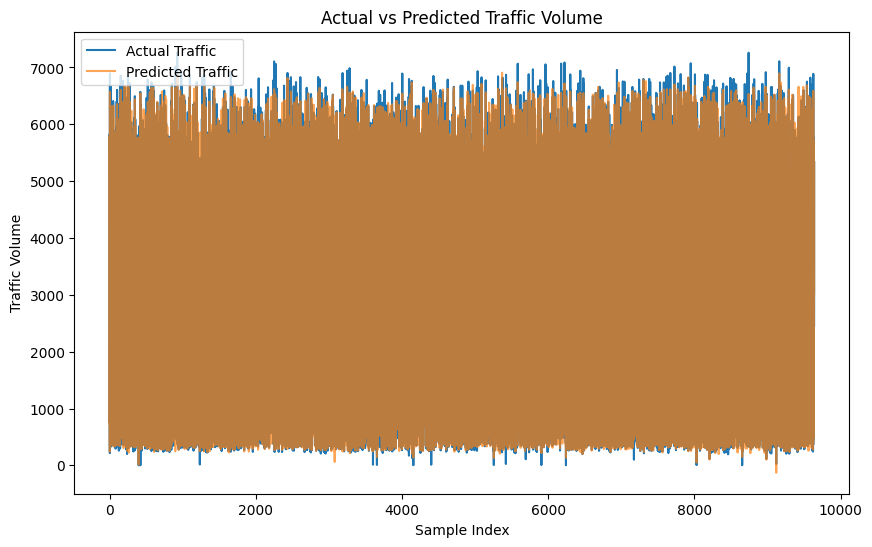

In [29]:
import matplotlib.pyplot as plt

# ---------------------------
# Show Predicted Traffic (In Original Scale)
# ---------------------------
# Invert the normalization of predictions and actual values
final_preds_inv = scaler_target.inverse_transform(final_preds.reshape(-1, 1))
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame to compare actual vs predicted traffic
results_df = pd.DataFrame({
    'Actual Traffic': y_test_inv.flatten(),
    'Predicted Traffic': final_preds_inv.flatten()
})

print("\nSample of Actual vs Predicted Traffic:")
print(results_df.head(10))

# Optionally, you can visualize the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual Traffic')
plt.plot(final_preds_inv, label='Predicted Traffic', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Predicted Traffic Volume')
plt.legend()
plt.show()